In [3]:
# import ROOT as rt
# from root_numpy import root2array, tree2array

import awkward as ak
import h5py
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
import json
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from prettytable import PrettyTable

import gpustat
gpustat.print_gpustat()
print(torch.cuda.is_available())
# os.environ['CUDA_VISIBLE_DEVICES']='4'

cmslpcgpu1.fnal.gov      Fri Jul 26 09:41:21 2024  555.42.02
[0] Tesla P100-PCIE-12GB | 45°C,  19 % | 11762 / 12288 MB | lbrennan(256M) lbrennan(324M) lbrennan(256M) lbrennan(324M) lbrennan(324M) lbrennan(324M) lbrennan(324M) lbrennan(324M) lbrennan(324M) cwfair(8978M)
True


In [1]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

SIGNAL_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*"]
SIGNAL_FILEPATHS = [
    lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*",
    lpc_fileprefix+"/Run3_2022preEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", 
    # lpc_fileprefix+"/Run3_2022preEE_merged/ZHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ZHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*",
    # lpc_fileprefix+"/Run3_2022preEE_merged/WHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/WHH_HHto2B2G_CV-1p0_C2V-1p0_C3-1p0_TuneCP5_13p6TeV/nominal/*"
]
BKG_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/ttHToGG/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ttHToGG/nominal/*",]


# SIGNAL_FILEPATHS = ["/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1/GluGluToHH/nominal/*", "/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1_preEE/GluGluToHH/nominal/*"]
# BKG_FILEPATHS = ["/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1/ttHToGG/nominal/*", "/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1_preEE/ttHToGG/nominal/*"]


In [4]:
class AMSGrad(optim.Optimizer):
    """Implements AMSGrad algorithm.
    It has been proposed in `On the Convergence of Adam and Beyond (https://openreview.net/forum?id=ryQu7f-RZ)`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSGrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSGrad, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', True)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

### Preprocessing

In [5]:
import glob

destdir = 'v1_merged_plots'
sig_samples_list = [ak.from_parquet(glob.glob(dir_path)) for dir_path in SIGNAL_FILEPATHS]
sig_samples_pq = ak.concatenate(sig_samples_list)
bkg_samples_list = [ak.from_parquet(glob.glob(dir_path)) for dir_path in BKG_FILEPATHS]
bkg_samples_pq = ak.concatenate(bkg_samples_list)
samples = {
    'sig': sig_samples_pq,
    'bkg': bkg_samples_pq,
}

# print(sig_samples_pq.fields)


In [6]:
pandas_samples = {}
high_level_fields = {
    'puppiMET_sumEt', 'puppiMET_pt', 'puppiMET_phi', # MET variables
    'DeltaPhi_j1MET', 'DeltaPhi_j2MET', # jet-MET variables
    'DeltaR_jg_min', 'n_jets', 'chi_t0', 'chi_t1', # jet variables
    'lepton1_pt' ,'lepton2_pt', 'pt', # lepton and diphoton pt
    'lepton1_eta', 'lepton2_eta', 'eta', # lepton and diphoton eta
    'lepton1_phi', 'lepton2_phi', 'phi', # lepton and diphoton phi
    'abs_CosThetaStar_CS', 'abs_CosThetaStar_jj', # angular variables
    'dijet_mass', # mass of b-dijet (resonance for H->bb)
    'leadBjet_leadLepton', 'leadBjet_subleadLepton', # deltaR btwn bjets and leptons (b/c b often decays to muons)
    'subleadBjet_leadLepton', 'subleadBjet_subleadLepton'
}

pandas_aux_samples = {}
high_level_aux_fields = {
    'mass', 'dijet_mass' # diphoton and bb-dijet mass
} # https://stackoverflow.com/questions/67003141/how-to-remove-a-field-from-a-collection-of-records-created-by-awkward-zip

for sample_name, sample in samples.items():
    pandas_samples[sample_name] = {
        field: ak.to_numpy(sample[field], allow_missing=False) for field in high_level_fields
    }
    pandas_aux_samples[sample_name] = {
        field: ak.to_numpy(sample[field], allow_missing=False) for field in high_level_aux_fields
    }

# del samples

# sig_frame = ak.to_dataframe(pandas_samples['sig'])
# sig_aux_frame = ak.to_dataframe(pandas_aux_samples['sig'])
# bkg_frame = ak.to_dataframe(pandas_samples['bkg'])
# bkg_aux_frame = ak.to_dataframe(pandas_aux_samples['bkg'])
sig_frame = pd.DataFrame(pandas_samples['sig'])
sig_aux_frame = pd.DataFrame(pandas_aux_samples['sig'])
bkg_frame = pd.DataFrame(pandas_samples['bkg'])
bkg_aux_frame = pd.DataFrame(pandas_aux_samples['bkg'])


In [7]:
# def convert(tree, target=0):
#     feature = tree2array(tree,
#                         branches = ['sumEt','MET','dPhi1','dPhi2','PhoJetMinDr','njets','Xtt0',
#                                    'Xtt1','pte1','pte2','ptmu1','ptmu2','fabs_CosThetaStar_CS','fabs_CosTheta_bb'])
#     if target == 0:
#         label = np.zeros(shape = feature.shape, dtype=[('label','f4')])
#     else:
#         label = np.ones(shape = feature.shape, dtype=[('label','f4')])
#     #data = nlr.merge_arrays([label,feature], flatten=True)
#     auxInfo = tree2array(tree,
#                          branches = ['mass_jj','mass_gg'])
#     return feature, auxInfo

# sigfile = rt.TFile.Open(SIGNAL_FILE)
# bkgfile = rt.TFile.Open(BKG_FILE)
# sigtree = sigfile.Get("BDT")
# bkgtree = bkgfile.Get("BDT")

# # sigfile.Print()
# # bkgfile.Print()

# for key in sigfile.GetListOfKeys():
#     name = key.GetName()
#     entries = sigfile.Get(name).GetEntries()
#     print('{} : {}'.format(name, entries))

# for key in bkgfile.GetListOfKeys():
#     name = key.GetName()
#     entries = bkgfile.Get(name).GetEntries()
#     print('{} : {}'.format(name, entries))

# signp, sig_auxnp = convert(sigtree, 1)
# bkgnp, bkg_auxnp = convert(bkgtree, 0)

# sig_frame = pd.DataFrame.from_records(signp)
# sig_aux_frame = pd.DataFrame.from_records(sig_auxnp)
# bkg_frame = pd.DataFrame.from_records(bkgnp)
# bkg_aux_frame = pd.DataFrame.from_records(bkg_auxnp)

# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

background_ = background[randix]
background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal,background_))
label = np.concatenate((sig_label,bkg_label))

data, data_test, label, label_test = train_test_split(
    data, label, test_size=0.25, random_state=None)

skf = StratifiedKFold(n_splits=5, shuffle=True)
# skf.get_n_splits(data, label)
print(skf)


StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


### Training

In [8]:
EPOCHS=10
model_file = 'SimpleDNN.torch'
config_file = 'BestConfig.json'
retrain=True

class EventHLF(Dataset):
    def __init__(self, data_x, data_y):
        self.len = data_x.shape[0]
        self.data_x = torch.from_numpy(data_x).float()
        self.data_y = torch.from_numpy(data_y).long()
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_x[idx], self.data_y[idx])


class SimpleDNN(nn.Module):
    def __init__(self, num_hiddens=2, initial_node=500, dropout=0.5):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(len(high_level_fields), initial_node)
        self.dropout = dropout
        self.hiddens = nn.ModuleList()
        nodes = [initial_node]
        for i in range(num_hiddens):
            nodes.append(int(nodes[i]/2))
            self.hiddens.append(nn.Linear(nodes[i],nodes[i+1]))
        self.out = nn.Linear(nodes[-1],2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for i in range(len(self.hiddens)):
            x = F.relu(self.hiddens[i](x))
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, 
                 monitor='val_loss',
                 min_delta=0,
                 patience=10):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.stopped_epoch = 0
        self.stop_training = False
        #print("This is my patience {}".format(patience))
    
    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15
        self.best_params = None
    
    def on_epoch_end(self, epoch, current_loss):
        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch + 1
                    self.stop_training = True
                self.wait += 1
            return  self.stop_training
        
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print('\nTerminated training for early stopping at epoch %04i' % 
                (self.stopped_epoch))

def train(num_epochs, model, criterion, optimizer,scheduler,volatile=False, data_loader=None):
    best_model = model.state_dict()
    best_acc = 0.0
    train_losses ,val_losses = [],[]
    callback = EarlyStopping(patience=20)
    callback.on_train_begin()
    breakdown = False
    for epoch in range(num_epochs):
        if breakdown:
            print("Early stopped.")
            break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train() # Set model to training mode
                volatile=False
            else:
                model.eval() # Set model to evaluate mode
                volatile=True
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (x_data, y_data) in enumerate(data_loader[phase]):
                x_data = Variable(x_data, requires_grad=not volatile).cuda() 
                y_data = Variable(y_data, requires_grad=False).cuda()
                if phase == 'training':
                    optimizer.zero_grad()
                # forward pass
                outputs = model(x_data)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, y_data)
                
                # backward + optimize only if in training phase
                if phase == 'training':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == y_data.data)
                #print("I finished %d batch" % batch_idx)
            
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = 100. * running_corrects / len(data_loader[phase].dataset)
            if phase == 'training':
                train_losses.append(epoch_loss)
            else:
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                print('Saving..')
                state = {
                        'net': model, #.module if use_cuda else net,
                        'epoch': epoch,
                        'best_acc': epoch_acc,
                        'train_loss': train_losses,
                        'val_loss': val_losses,
                        }
                torch.save(state, model_file)
                best_acc = epoch_acc
                best_model = model.state_dict()
            if phase == 'validation':
                breakdown = callback.on_epoch_end(epoch, -epoch_acc)
                # breakdown = callback.on_epoch_end(epoch, epoch_loss)
                
         
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model)
    print('-' * 10)
    return best_acc, train_losses, val_losses


In [8]:
space  = [Integer(1, 5, name='max_depth'),
          Integer(200, 1000, name='initial_nodes'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Real(0.01,0.9,name='dropout'),
          Integer(4000,4001,name='batch_size'),
          Real(10**-6, 10**-4, "log-uniform", name='L2_reg')
        ]
# L1 reg: https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    fom = []
    for train_index, test_index in skf.split(data, label):
        train_loader = DataLoader(EventHLF(data[train_index], label[train_index]), batch_size = int(X['batch_size']), shuffle=True)
        val_loader = DataLoader(EventHLF(data[test_index], label[test_index]), batch_size = int(X['batch_size']), shuffle=True)
        data_loader = {"training": train_loader, "validation": val_loader} 

        model = SimpleDNN(X['max_depth'], X['initial_nodes'], X['dropout']).cuda()
        optimizer = AMSGrad(model.parameters(), lr=X['learning_rate'], weight_decay=X['L2_reg'])
        criterion= nn.NLLLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
        best_acc, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
        fom.append(best_acc)
    Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
    print("Average best_acc across k-fold: {}".format(Y))
    return -Y

# res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# print("Best parameters: {}".format(res_gp.x))
# best_max_depth = int(res_gp.x[0])
# best_initial_nodes = int(res_gp.x[1])
# best_learning_rate = float(res_gp.x[2])
# best_dropout = float(res_gp.x[3])
# best_batch_size = int(res_gp.x[4])
# best_L2_reg = float(res_gp.x[5])

# best_conf = {"max_depth": best_max_depth,
#           "initial_nodes": best_initial_nodes,
#           "learning_rate": best_learning_rate,
#           "dropout": best_dropout,
#           "batch_size": best_batch_size,
#           "L2_reg": best_L2_reg}
# with open(config_file, 'w') as config:
#     json.dump(best_conf, config)
#     print("Save best configuration to {}".format(config_file))

# EPOCHS=100
# train_index, test_index = skf.split(data, label).next()
# model = SimpleDNN(best_max_depth, best_initial_nodes, best_dropout).cuda()
# train_loader = DataLoader(EventHLF(data[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
# val_loader = DataLoader(EventHLF(data[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
# data_loader = {"training": train_loader, "validation": val_loader}
# optimizer = AMSGrad(model.parameters(), lr=best_learning_rate)
# criterion= nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
# best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)

# torch.save(model.state_dict(), model_file)

with open(config_file) as f:
    best_conf = json.load(f)
    print(best_conf)
print("Loaded best configuration from {}".format(config_file))

fom = []
# model = SimpleDNN(best_max_depth, best_initial_nodes, best_dropout).cuda()
# optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
criterion= nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
train_losses_arr, val_losses_arr = [], []
EPOCHS = 100
for fold_idx, (train_index, test_index) in enumerate(skf.split(data, label)):
    print('='*50)
    print(f'Fold {fold_idx}')
    print('='*50)
    model = SimpleDNN(best_conf["max_depth"], best_conf["initial_nodes"], best_conf["dropout"]).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=5)
    
    train_loader = DataLoader(EventHLF(data[train_index], label[train_index]), batch_size = best_conf['batch_size'], shuffle=True)
    val_loader = DataLoader(EventHLF(data[test_index], label[test_index]), batch_size = best_conf['batch_size'], shuffle=True)
    data_loader = {"training": train_loader, "validation": val_loader}

    best_acc, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    model_i_file = f'SimpleDNN_{fold_idx}.torch'
    torch.save(model.state_dict(), model_i_file)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))

{'max_depth': 2, 'initial_nodes': 1000, 'learning_rate': 0.0025269885651973386, 'dropout': 0.01, 'batch_size': 4001, 'L2_reg': 1e-06}
Loaded best configuration from BestConfig.json
Fold 0
Epoch 0/99


/tmp/ipykernel_3848883/2024701598.py:81: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706619781071/work/torch/csrc/utils/python_arg_parser.cpp:1519.)
  grad = grad.add(group['weight_decay'], p.data)


training Loss: 0.0001 Acc: 87.5497
validation Loss: 0.0001 Acc: 88.4906
Saving..
Epoch 1/99
training Loss: 0.0001 Acc: 88.7048
validation Loss: 0.0001 Acc: 88.9551
Saving..
Epoch 2/99
training Loss: 0.0001 Acc: 89.1095
validation Loss: 0.0001 Acc: 89.1259
Saving..
Epoch 3/99
training Loss: 0.0001 Acc: 89.2953
validation Loss: 0.0001 Acc: 89.2030
Saving..
Epoch 4/99
training Loss: 0.0001 Acc: 89.4653
validation Loss: 0.0001 Acc: 89.4043
Saving..
Epoch 5/99
training Loss: 0.0001 Acc: 89.5899
validation Loss: 0.0001 Acc: 89.4398
Saving..
Epoch 6/99
training Loss: 0.0001 Acc: 89.6605
validation Loss: 0.0001 Acc: 89.6038
Saving..
Epoch 7/99
training Loss: 0.0001 Acc: 89.7698
validation Loss: 0.0001 Acc: 89.4520
Epoch 8/99
training Loss: 0.0001 Acc: 89.8368
validation Loss: 0.0001 Acc: 89.7097
Saving..
Epoch 9/99
training Loss: 0.0001 Acc: 89.8446
validation Loss: 0.0001 Acc: 89.6981
Epoch 10/99
training Loss: 0.0001 Acc: 89.9044
validation Loss: 0.0001 Acc: 89.7550
Saving..
Epoch 11/99
trai

In [9]:
with open(config_file) as f:
    best_conf = json.load(f)
    print(best_conf)
print("Loaded best configuration from {}".format(config_file))
model = SimpleDNN(best_conf["max_depth"], best_conf["initial_nodes"], best_conf["dropout"]).cuda()
# model.load_state_dict(torch.load(model_file))
# print("Loaded best model parameter from {}".format(model_file))


{'max_depth': 2, 'initial_nodes': 1000, 'learning_rate': 0.0025269885651973386, 'dropout': 0.01, 'batch_size': 4001, 'L2_reg': 1e-06}
Loaded best configuration from BestConfig.json


Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.2118  |       0.9706      |    0.3237 +/- 0.0034     |
|   0.3644  |       0.9500      |    0.2353 +/- 0.0023     |
|   0.5462  |       0.9198      |    0.1630 +/- 0.0020     |
|   0.9197  |       0.7538      |    0.0408 +/- 0.0012     |
|   0.9836  |       0.5777      |    0.0119 +/- 0.0006     |
|   0.9971  |       0.3839      |    0.0030 +/- 0.0002     |
+-----------+-------------------+--------------------------+
Saved ROC.


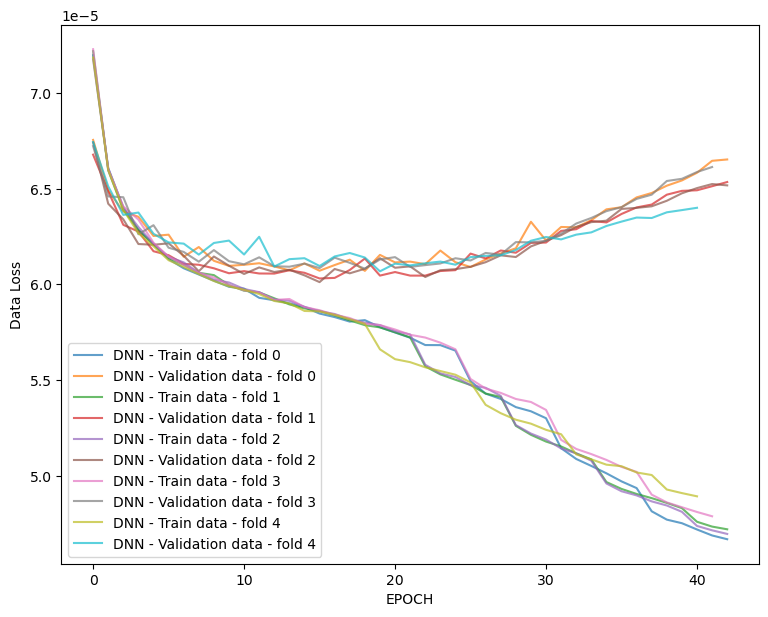

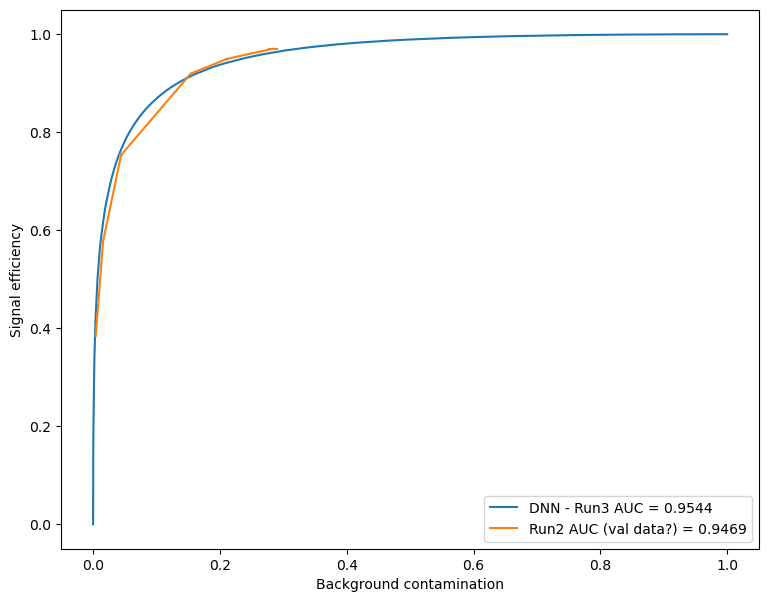

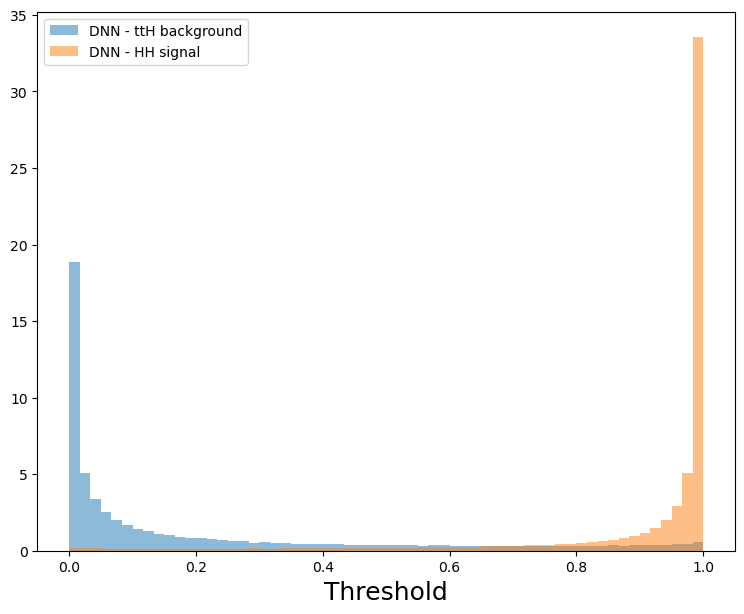

In [10]:
fprs = []
base_tpr = np.linspace(0, 1, 5000)
# TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]
thresholds = []
test_loader = DataLoader(EventHLF(data_test, label_test), batch_size = best_conf['batch_size'], shuffle=False)
all_pred = np.zeros(shape=(len(data_test),2))
all_label = np.zeros(shape=(len(label_test)))
criterion= nn.NLLLoss()
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0])] = value

for fold_idx in range(skf.get_n_splits()):
    model.load_state_dict(torch.load(f'SimpleDNN_{fold_idx}.torch'))
    model.eval()
    with torch.no_grad():
        for batch_idx, (x_val, y_val) in enumerate(test_loader):
            pred = model(Variable(x_val.float().cuda(), True)).cpu().data.numpy()
            fill_array(all_pred, pred, batch_idx, best_conf['batch_size'])
            fill_array(all_label, y_val.numpy(), batch_idx, best_conf['batch_size'])
            

    fpr, tpr, threshold = roc_curve(all_label, np.exp(all_pred)[:,1])
    
    fpr = np.interp(base_tpr, tpr, fpr)
    threshold = np.interp(base_tpr, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr)

DNN_perf = {
    'train losses': train_losses_arr,
    'val losses': val_losses_arr,
    'fprs': fprs.tolist(),
    'thresholds': thresholds.tolist(),
    'mean_fprs': mean_fprs.tolist(),
    'mean_thresholds': mean_thresholds.tolist(),
    'base_tpr': base_tpr.tolist(),
    'mean_area': float(mean_area),
    'all_pred': all_pred.tolist(),
    'all_label': all_label.tolist()
}

with open('DNN_perf.json', 'w') as f:
    json.dump(DNN_perf, f)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

with open('IN_perf.json', 'r') as f:
    IN_perf = json.load(f)

plt.figure(figsize=(9,7))
# for fold_idx in range(skf.get_n_splits()):
#     plt.plot(range(len(IN_perf['train losses'][fold_idx])), IN_perf['train losses'][fold_idx], label=f"IN - Train data - fold {fold_idx}", alpha=0.7)
#     plt.plot(range(len(IN_perf['train losses'][fold_idx])), IN_perf['val losses'][fold_idx], label=f"IN Validation data - fold {fold_idx}", alpha=0.7)
for fold_idx in range(skf.get_n_splits()):
    plt.plot(range(len(train_losses_arr[fold_idx])), train_losses_arr[fold_idx], label=f"DNN - Train data - fold {fold_idx}", alpha=0.7)
    plt.plot(range(len(train_losses_arr[fold_idx])), val_losses_arr[fold_idx], label=f"DNN - Validation data - fold {fold_idx}", alpha=0.7)
# plt.plot(range(len(IN_perf['train losses'][0])), IN_perf['train losses'][0], label="IN - Train data")
# plt.plot(range(len(IN_perf['train losses'][0])), IN_perf['val losses'][0], label="IN - Validation data" )
# plt.plot(range(len(train_losses_arr[0])), train_losses_arr[0], label="DNN - Train data")
# plt.plot(range(len(train_losses_arr[0])), val_losses_arr[0], label="DNN - Validation data" )
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('EPOCH')
plt.ylabel('Data Loss')

# plt.figure(figsize=(9,7))
# plt.plot(range(EPOCHS), val_losses, label="val losses vs. epoch")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
# plt.legend(loc='best')
# plt.xlabel('EPOCH')
# plt.ylabel('Validation data Loss')

run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
plt.figure(figsize=(9,7))
# plt.plot(IN_perf['mean_fprs'], IN_perf['base_tpr'],label="IN - Run3 AUC = %.4f" % IN_perf['mean_area'])
plt.plot(mean_fprs, base_tpr,label="DNN - Run3 AUC = %.4f" % mean_area)
plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 AUC (val data?) = {}".format(0.9469))
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')



plt.figure(figsize=(9,7))
# plt.hist(np.exp(np.array(IN_perf['all_pred']))[np.array(IN_perf['all_label'])==0,1], bins=60, label='IN - ttH background',alpha=0.5, density=True)
# plt.hist(np.exp(np.array(IN_perf['all_pred']))[np.array(IN_perf['all_label'])==1,1], bins=60, label='IN - HH signal', alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==0,1], bins=60, label='DNN - ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==1,1], bins=60, label='DNN - HH signal', alpha=0.5, density=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

with h5py.File("DNN_ROC.h5","w") as out:
    out['FPR'] = mean_fprs
    out['dFPR'] = std_fprs
    out['TPR'] = base_tpr
    out['Thresholds'] = mean_thresholds
    print("Saved ROC.")


### Performance

## Check mass sculpting

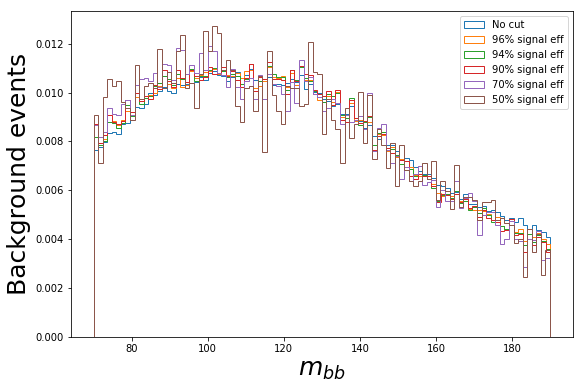

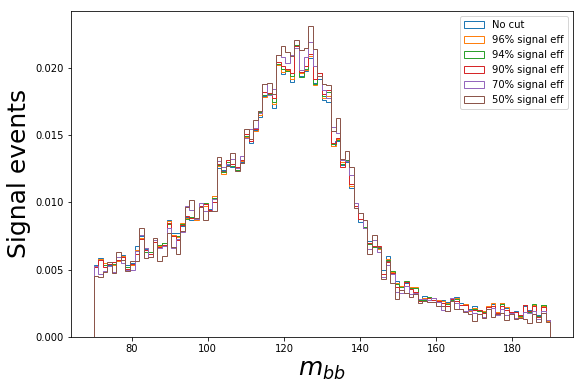

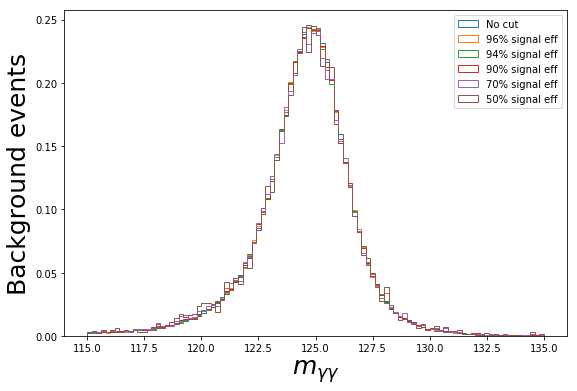

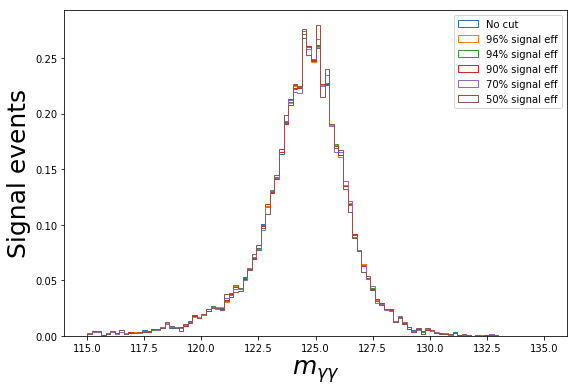

In [ ]:
fontsize=25

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass_jj'], bins=100, histtype='step', label='No cut',normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass_jj'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass_jj'], bins=100, histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass_jj'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass_gg'], bins=100, range=(115,135), histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass_gg'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass_gg'], bins=100, range=(115,135), histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass_gg'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, 
             histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

### BDT benchmark

In [11]:
import xgboost as xgb

In [12]:
for col in sig_frame.columns:
    print(col)

bdt_train = xgb.DMatrix(
    data=data, label=label, missing=-999.0, feature_names=sig_frame.columns
)
bdt_test = xgb.DMatrix(
    data=data_test, label=label_test, missing=-999.0, feature_names=sig_frame.columns
)

chi_t1
puppiMET_phi
subleadBjet_leadLepton
pt
chi_t0
abs_CosThetaStar_jj
lepton1_pt
lepton2_phi
DeltaR_jg_min
leadBjet_leadLepton
lepton2_pt
abs_CosThetaStar_CS
lepton1_eta
dijet_mass
subleadBjet_subleadLepton
puppiMET_sumEt
leadBjet_subleadLepton
DeltaPhi_j2MET
DeltaPhi_j1MET
eta
phi
puppiMET_pt
lepton1_phi
lepton2_eta
n_jets


In [13]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
# param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')]

num_trees = 100  # number of trees to make

In [14]:
# Train bdt
booster = xgb.train(param,bdt_train,num_boost_round=num_trees)

# Print perf on test dataset
print(booster.eval(bdt_test))

[0]	eval-error:0.095861	eval-logloss:0.226667


Saved ROC.
BDT performance
Threshold 	Signal Efficiency 	Background contamination
0.2914  	   0.9704   		  0.2724
0.4335  	   0.9498   		  0.1972
0.5909  	   0.9196   		  0.1353
0.9017  	   0.7536   		  0.03108
0.9697  	   0.5777   		  0.007957
0.9908  	   0.3837   		  0.001568


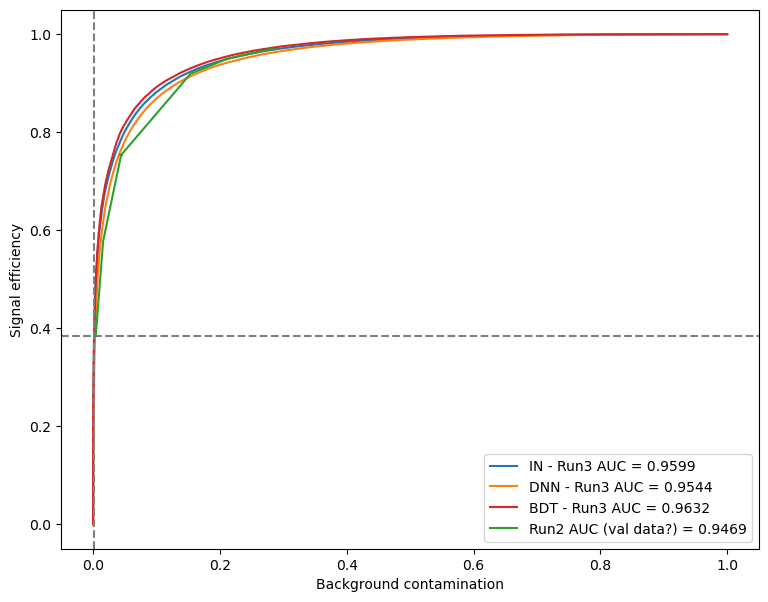

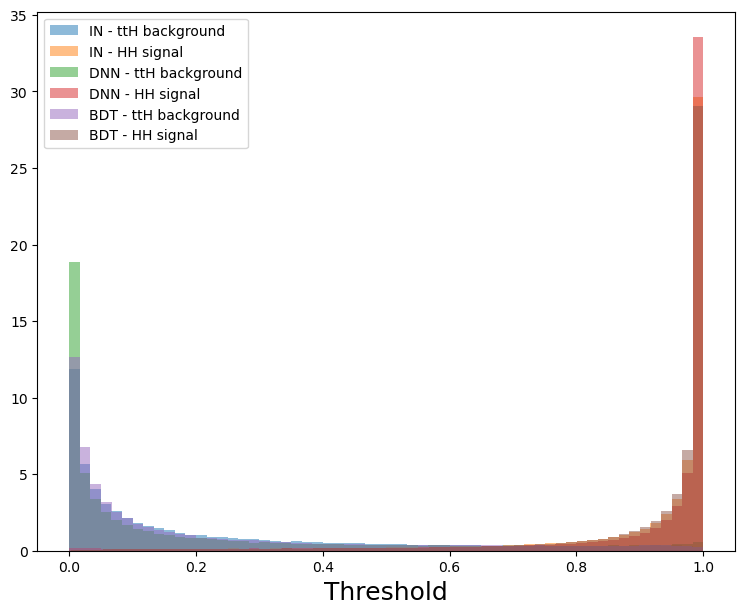

In [15]:
bdt_pred = booster.predict(bdt_test)

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(label_test, bdt_pred)
area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("BDT_ROC.h5","w") as out:
    out['FPR'] = fpr_bdt
    out['TPR'] = tpr_bdt
    out['Thresholds'] = thresholds_bdt
    print("Saved ROC.")

# TPR_thresholds = [0.96, 0.94, 0.935, 0.9, 0.7, 0.5, 0.3]
TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]
print("BDT performance")
# BDTtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
# NNtable.float_format = ".4"
# for TPR_threshold in TPR_thresholds:
#     thres_idx = np.argmax(base_tpr>TPR_threshold)
#     BDTtable.add_row([thresholds_bdt[thres_idx], base_tpr[thres_idx], f"{fpr_bdt[thres_idx]:.4f} +/- N/A"])
# print(BDTtable)
print("Threshold \tSignal Efficiency \tBackground contamination")
for TPR_threshold in TPR_thresholds:
    thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
    print("{0:.4}  \t   {1:.4}   \t\t  {2:.4}".format(thresholds_bdt[thres_bdt_idx], tpr_bdt[thres_bdt_idx],  fpr_bdt[thres_bdt_idx]))


# TPR_threshold = 0.96
# thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
# print("Signal efficiency = {} @ {} ttH background contamination".format(tpr_bdt[thres_bdt_idx], fpr_bdt[thres_bdt_idx]))
# print("NN score threshold = {}".format(thresholds_bdt[thres_bdt_idx]))

plt.figure(figsize=(9,7))
plt.plot(IN_perf['mean_fprs'], IN_perf['base_tpr'],label="IN - Run3 AUC = %.4f" % IN_perf['mean_area'])
plt.plot(mean_fprs, base_tpr,label="DNN - Run3 AUC = %.4f" % mean_area)
plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 AUC (val data?) = {}".format(0.9469))
plt.plot(fpr_bdt,tpr_bdt,label="BDT - Run3 AUC = %.4f" % area_bdt)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
plt.axhline(tpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')
plt.axvline(fpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(np.array(IN_perf['all_pred']))[np.array(IN_perf['all_label'])==0,1], bins=60, label='IN - ttH background',alpha=0.5, density=True)
plt.hist(np.exp(np.array(IN_perf['all_pred']))[np.array(IN_perf['all_label'])==1,1], bins=60, label='IN - HH signal', alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==0,1], bins=60, label='DNN - ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==1,1], bins=60, label='DNN - HH signal', alpha=0.5, density=True)
plt.hist(bdt_pred[label_test==0], bins=60, label='BDT - ttH background',alpha=0.5, density=True)
plt.hist(bdt_pred[label_test==1], bins=60, label='BDT - HH signal', alpha=0.5, density=True)
plt.xlabel("Threshold", fontsize=18)
#plt.axvline(thresholds_bdt[thres_bdt_idx], ls='--',color='tab:gray')
plt.legend(loc='best')

Saved ROC.
BDT performance
Threshold 	Signal Efficiency 	Background contamination
-0.1169  	   0.96   		  0.4249
-0.09705  	   0.94   		  0.3544
-0.09088  	   0.935   		  0.3338
-0.06616  	   0.9   		  0.2547
0.0121  	   0.7   		  0.08297
0.06435  	   0.5   		  0.02809
0.1175  	   0.3003   		  0.007152


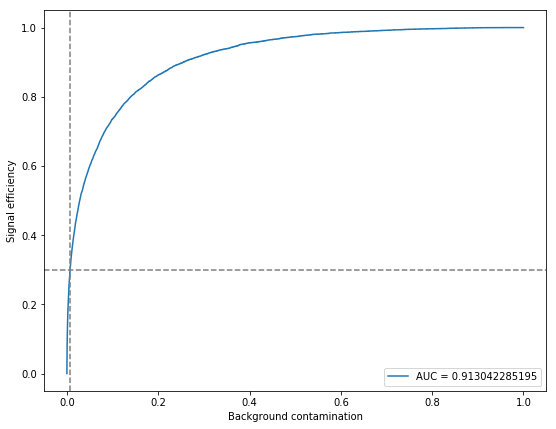

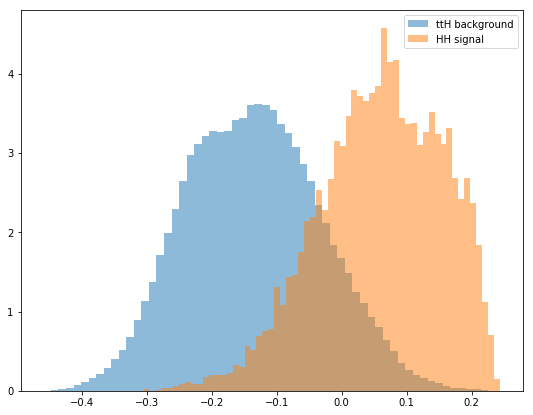

In [ ]:
bdtfile = rt.TFile.Open("TMVA.root")
bdttree = bdtfile.Get("TestTree")
bdtscore = tree2array(bdttree,
                        branches = ['classID','BDT'])
bdtframe = pd.DataFrame.from_records(bdtscore)
bdtarray = bdtframe.values

bdt_pred = bdtarray[:,1]
bdt_target = np.zeros(shape=len(bdt_pred))
bdt_target[bdtarray[:,0]==0] = 1 # Signal
bdt_target[bdtarray[:,0]==1] = -1 # Background

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(bdt_target, bdt_pred)
area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("BDT_ROC.h5","w") as out:
    out['FPR'] = fpr_bdt
    out['TPR'] = tpr_bdt
    out['Thresholds'] = thresholds_bdt
    print("Saved ROC.")

TPR_thresholds = [0.96, 0.94, 0.935, 0.9, 0.7, 0.5, 0.3]
print("BDT performance")
print("Threshold \tSignal Efficiency \tBackground contamination")
for TPR_threshold in TPR_thresholds:
    thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
    print("{0:.4}  \t   {1:.4}   \t\t  {2:.4}".format(thresholds_bdt[thres_bdt_idx], tpr_bdt[thres_bdt_idx],  fpr_bdt[thres_bdt_idx]))


# TPR_threshold = 0.96
# thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
# print("Signal efficiency = {} @ {} ttH background contamination".format(tpr_bdt[thres_bdt_idx], fpr_bdt[thres_bdt_idx]))
# print("NN score threshold = {}".format(thresholds_bdt[thres_bdt_idx]))

plt.figure(figsize=(9,7))
plt.plot(fpr_bdt,tpr_bdt,label="AUC = {}".format(area_bdt))
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
plt.axhline(tpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')
plt.axvline(fpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(bdt_pred[bdt_target==-1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(bdt_pred[bdt_target==1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds_bdt[thres_bdt_idx], ls='--',color='tab:gray')
plt.legend(loc='best')

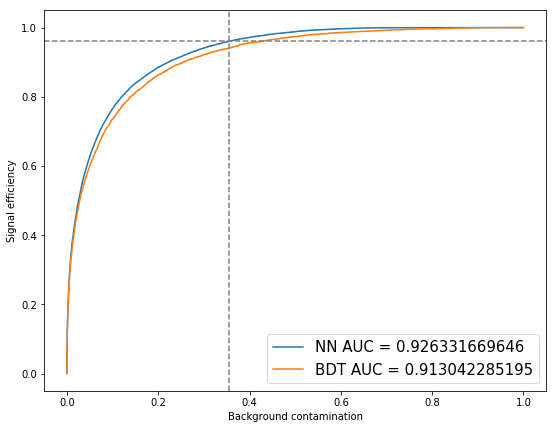

In [ ]:
### Compare
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,label="NN AUC = {}".format(area))
plt.plot(fpr_bdt,tpr_bdt,label="BDT AUC = {}".format(area_bdt))
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
thres_idx = np.argmax(tpr>0.96)
# plt.xlim(0.01,0.6)
# plt.ylim(0.2,1)
plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='best',fontsize=15)

## Show variables used

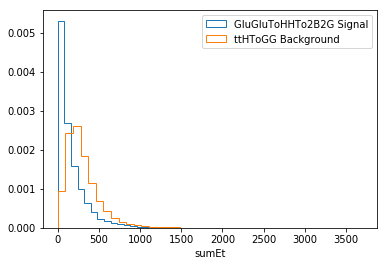

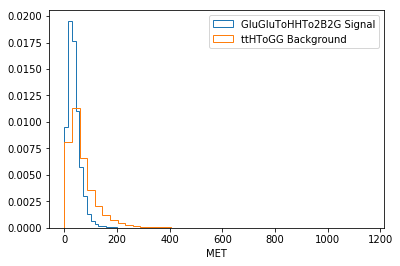

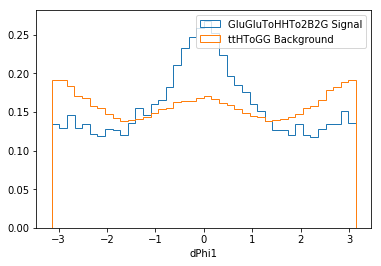

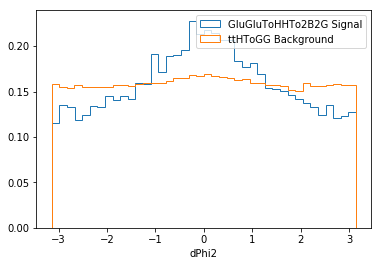

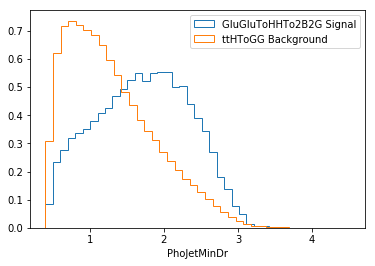

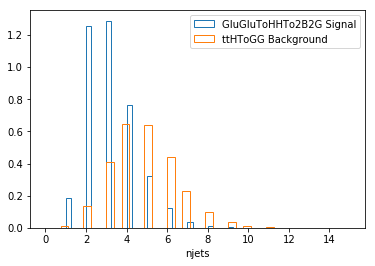

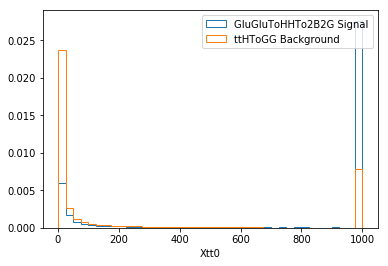

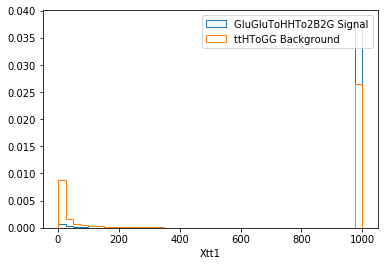

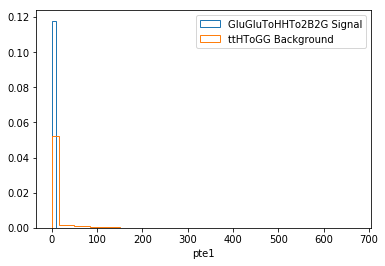

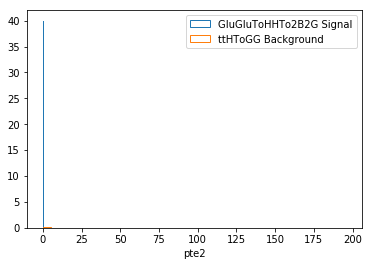

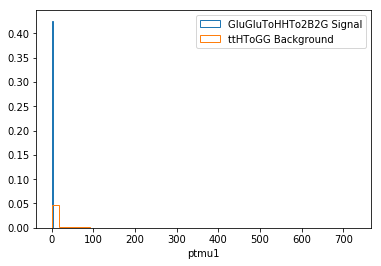

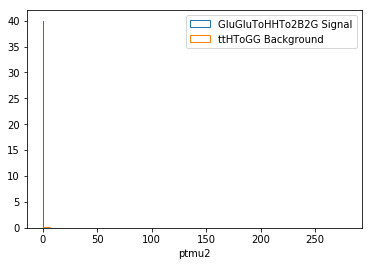

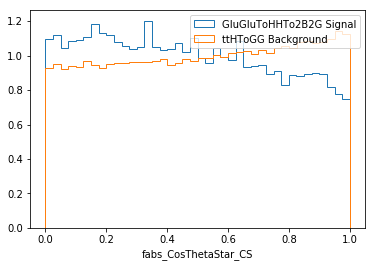

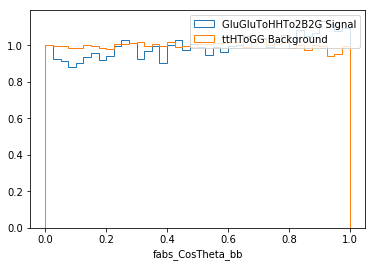

In [ ]:
HLFs = ['sumEt','MET','dPhi1','dPhi2','PhoJetMinDr','njets','Xtt0',
        'Xtt1','pte1','pte2','ptmu1','ptmu2','fabs_CosThetaStar_CS','fabs_CosTheta_bb']

for hlf in HLFs:
    plt.figure()
    plt.hist(sig_frame[hlf], bins=40, normed=True, histtype='step', label='GluGluToHHTo2B2G Signal')
    plt.hist(bkg_frame[hlf], bins=40, normed=True, histtype='step', label='ttHToGG Background')
    plt.xlabel(hlf)
    plt.legend(loc='best')
    

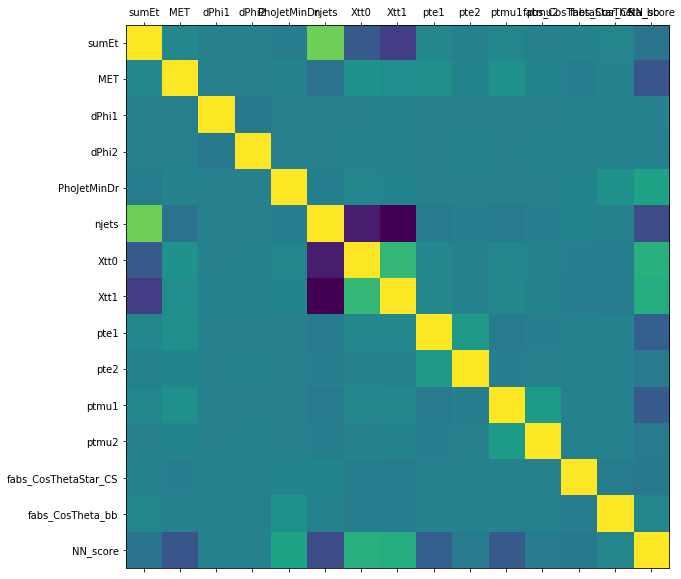

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

plot_corr(bkg_frame)